# Advection test case

So far, we have just been projecting sensor functions back and forth. Now let's consider actually using the supermesh projection in a mesh adaptive simulation.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
import firedrake.supermeshing as supermesh
from thetis import create_directory

/home/joe/software/firedrake-pragmatic/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/joe/software/firedrake-pragmatic/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
from adapt_utils.adapt.recovery import DoubleL2ProjectorHessian
from adapt_utils.adapt.metric import steady_metric, space_time_normalise
from adapt_utils.tracer.options import TracerOptions

Recall the hand-coded supermesh projection operator and its hand-coded adjoint from before:

In [3]:
def supermesh_project(src, tgt, check_mass=False, mixed_mass_matrix=None, solver=None):
    source_space = src.function_space()
    target_space = tgt.function_space()
    
    # Step 1: Form the RHS:
    #    rhs := Mst * src
    Mst = mixed_mass_matrix or supermesh.assemble_mixed_mass_matrix(source_space, target_space)
    with tgt.dat.vec_ro as vt:
        rhs = vt.copy()
    with src.dat.vec_ro as vs:
        Mst.mult(vs, rhs)
    
    # Step 2: Solve the linear system for the target:
    #    Mt * tgt = rhs
    ksp = solver or PETSc.KSP().create()
    if solver is None:
        Mt = assemble(inner(TrialFunction(target_space), TestFunction(target_space))*dx).M.handle
        ksp.setOperators(Mt)
        ksp.setFromOptions()
    with tgt.dat.vec as vt:
        ksp.solve(rhs, vt)
    
    if check_mass:
        assert np.allclose(assemble(src*dx), assemble(tgt*dx))

In [4]:
def supermesh_project_b(tgt_b, src_b, mixed_mass_matrix=None, solver=None):
    source_space = src_b.function_space()
    target_space = tgt_b.function_space()
    
    # Adjoint of step 2: Solve the linear system for the target:
    #    Mt^T * sol = tgt_b
    ksp = solver or PETSc.KSP().create()
    if solver is None:
        Mt = assemble(inner(TrialFunction(target_space), TestFunction(target_space))*dx).M.handle
        ksp.setOperators(Mt.transpose())
        ksp.setFromOptions()
    with tgt_b.dat.vec_ro as rhs:
        sol = rhs.copy()
        ksp.solve(rhs, sol)
    
    # Adjoint of 1: Multiply with the tranpose mass matrix
    #    src_b := Mst^T * sol
    Mst = mixed_mass_matrix or supermesh.assemble_mixed_mass_matrix(source_space, target_space)
    with src_b.dat.vec_ro as vs:
        Mst.multTranspose(sol, vs)

Set up a simple advection-diffusion problem:

<IPython.core.display.Javascript object>


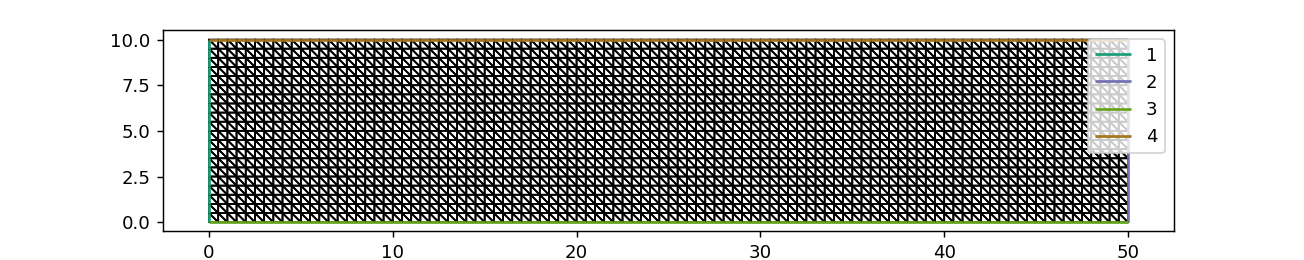

In [5]:
n = 2
dt = 1/n
initial_mesh = RectangleMesh(50*n, 10*n, 50, 10)
base_velocity = [1.0, 0.0]
base_diffusivity = 1e-6
params = {"ksp_type": "gmres", "pc_type": "sor"}

fig, axes = plt.subplots(figsize=(10, 2))
triplot(initial_mesh, axes=axes)
axes.legend();

In [6]:
def initial_condition(fs):
    mesh2d = fs.mesh()
    x, y = SpatialCoordinate(mesh2d)
    return interpolate(exp(-0.2*((x-10)**2 + (y-5)**2)), fs)

In [7]:
def final_time_condition(fs):
    mesh2d = fs.mesh()
    x, y = SpatialCoordinate(mesh2d)
#     return interpolate(conditional(le((x-40)**2 + (y-5)**2, 5), 1, 0), fs)
    return interpolate(exp(-0.2*((x-40)**2 + (y-5)**2)), fs)

<IPython.core.display.Javascript object>


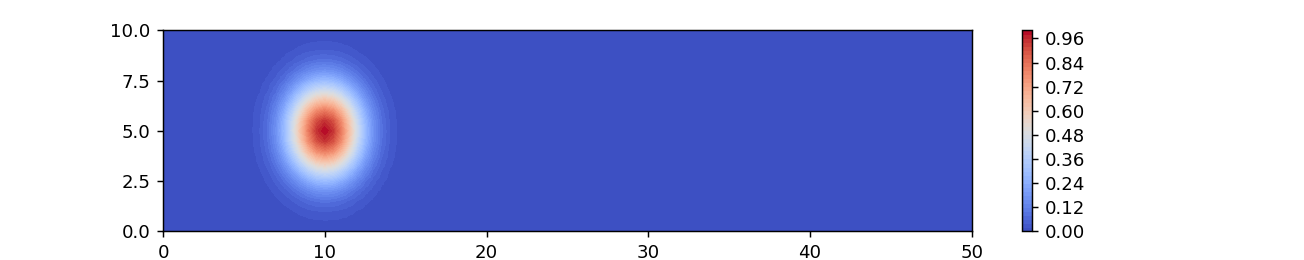

In [8]:
initial_space = FunctionSpace(initial_mesh, "CG", 1)

fig, axes = plt.subplots(figsize=(10, 2))
fig.colorbar(tricontourf(initial_condition(initial_space), axes=axes, cmap='coolwarm', levels=50), ax=axes);

A simple $\mathbb P1$ advection-diffusion solver with SUPG stabilisation:

In [9]:
def solve_tracer(initial_condition, time, end_time, dt, exporter=None, export_func=None):
    V = initial_condition.function_space()
    trial, test = TrialFunction(V), TestFunction(V)
    c = Function(V, name="Concentration")
    c_ = Function(V).assign(initial_condition)  # Lagged solution
    c.assign(c_)
    
    # Fields and parameters
    u = Constant(as_vector(base_velocity))
    nu = Constant(base_diffusivity)
    dtc = Constant(dt)
    
    # SUPG stabilisation
    tau = 0.5*CellSize(V.mesh())/sqrt(inner(u, u))
    test = test + tau*dot(u, grad(test))
    
    def G(C):
        return dt*(inner(test*u, grad(C)) + nu*inner(grad(test), grad(C)))*dx
    
    # Time derivative
    a = inner(test, trial)*dx
    L = inner(test, c_)*dx
    
    # Crank-Nicolson
    a += 0.5*G(trial)
    L -= 0.5*G(c_)
    
    problem = LinearVariationalProblem(a, L, c)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    while time < end_time:
        if export_func is not None:
            export_func(c)
        if exporter is not None:
            exporter.write(c)
        solver.solve()
        c_.assign(c)
        time += dt
        
    return c

In [10]:
create_directory('plots/fixed_mesh')
exporter = File('plots/fixed_mesh/forward.pvd')
sol = solve_tracer(initial_condition(initial_space), 0.0, 30.0, dt, exporter=exporter)

The continuous adjoint is straightforward (see [Wallwork et al 2020a](https://zenodo.org/record/3653373), eq. 38).

For the forward solve, we used Crank-Nicolson timestepping. Writing the PDE in the form

$$\frac{\partial u}{\partial t}=G(u),$$

we sought $u^{(n+1)}$ such that

$$\frac{u^{(n+1)}-u^{(n)}}{\Delta t}=\frac12\left(G\left(u^{(n)}\right) + G\left(u^{(n+1)}\right)\right).$$

The adjoint of Crank-Nicolson is given by

$$\frac{u^{(n)}-u^{(n-1)}}{\Delta t}=\frac12\left(G\left(u^{(n-1)}\right) + G\left(u^{(n)}\right)\right).$$

That is, just Crank-Nicolson with the time direction reversed!

In [11]:
def solve_tracer_adjoint(final_time_condition, time, end_time, dt, exporter=None, export_func=None):
    V = final_time_condition.function_space()
    trial, test = TrialFunction(V), TestFunction(V)
    c = Function(V, name="Adjoint concentration")
    c_ = Function(V).assign(final_time_condition)  # Lagged solution
    c.assign(c_)
    
    # Fields and parameters
    u = Constant(as_vector(base_velocity))
    nu = Constant(base_diffusivity)
    dtc = Constant(dt)
    
    # SUPG stabilisation
    tau = 0.5*CellSize(V.mesh())/sqrt(inner(u, u))
    test = test + tau*dot(-u, grad(test))
    
    n = FacetNormal(V.mesh())
    
    def G(C):  # NOTE: Boundary contribution
        return dt*(-inner(test, div(u*C)) + nu*inner(grad(test), grad(C)))*dx + dt*test*C*dot(u, n)*ds
    
    # Time derivative
    a = inner(test, trial)*dx
    L = inner(test, c_)*dx
    
    # Crank-Nicolson
    a += 0.5*G(trial)
    L -= 0.5*G(c_)
    
    problem = LinearVariationalProblem(a, L, c)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    while time > end_time:
        if export_func is not None:
            export_func(c)
        if exporter is not None:
            exporter.write(c)
        solver.solve()
        c_.assign(c)
        time -= dt
        
    return c

In [12]:
ftc = final_time_condition(initial_space)
exporter = File('plots/fixed_mesh/adjoint.pvd')
sol = solve_tracer_adjoint(ftc, 30.0, 0.0, dt, exporter=exporter)

Check restarting works okay (see VTK output).

In [15]:
checkpoints = [initial_condition(initial_space)]
num_windows = 8
t = 0.0
end_time = 30.0
window_time = end_time/num_windows
exporter = File('plots/fixed_mesh/forward.pvd')
for i in range(num_windows):
    checkpoints.append(solve_tracer(checkpoints[-1], i*window_time, (i+1)*window_time, dt, exporter=exporter))

<IPython.core.display.Javascript object>


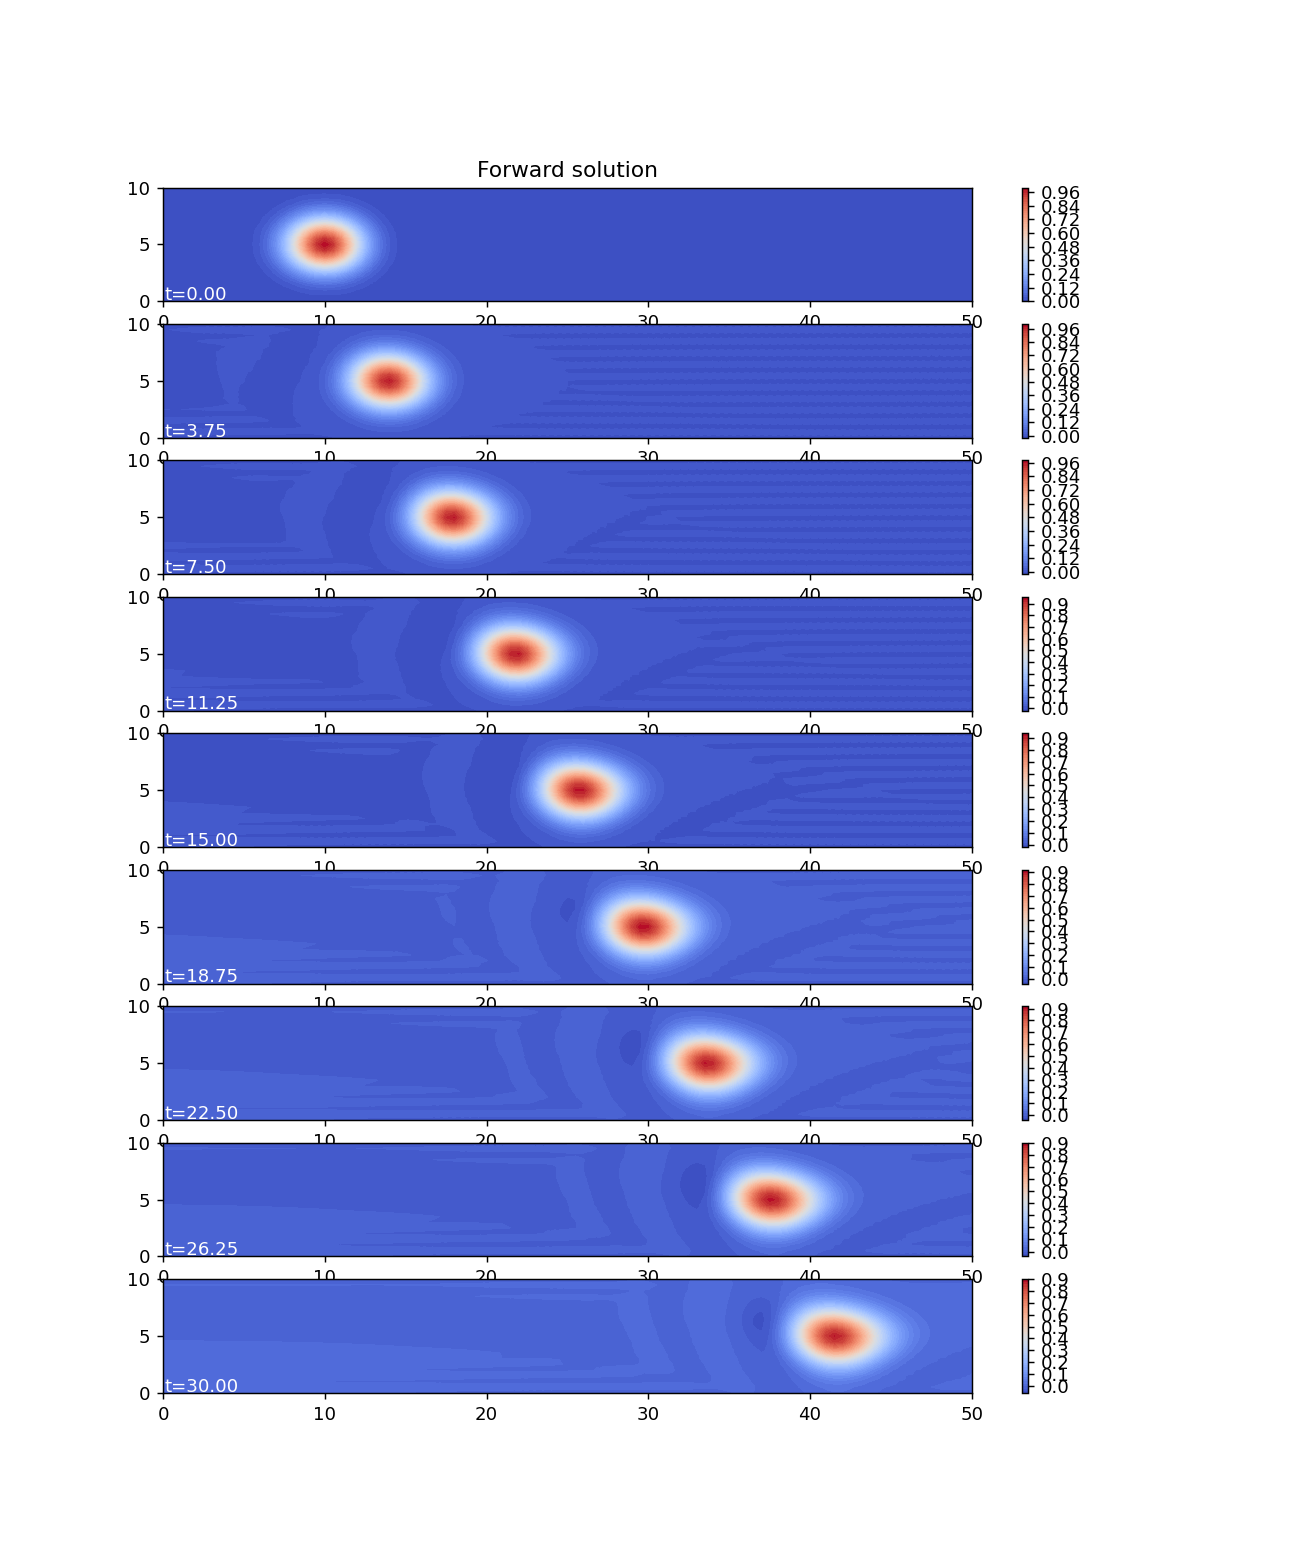

In [16]:
fig, axes = plt.subplots(len(checkpoints), figsize=(10, 12))
axes[0].set_title("Forward solution")
for i, chk in enumerate(checkpoints):
    fig.colorbar(tricontourf(chk, axes=axes[i], cmap='coolwarm', levels=50), ax=axes[i]);
    axes[i].annotate('t={:.2f}'.format(i*end_time/num_windows), (0.1, 0.1), color='white');

In [18]:
num_windows = 8
adj_checkpoints = [Function(initial_space) for i in range(num_windows)]
adj_checkpoints[-1].assign(final_time_condition(initial_space))
end_time = 30.0
window_time = end_time/num_windows
exporter = File('plots/fixed_mesh/forward.pvd')
for i in range(num_windows-1, -1, -1):
    chk = solve_tracer_adjoint(adj_checkpoints[i], (i+1)*window_time, i*window_time, dt, exporter=exporter)
    if i > 0:
        adj_checkpoints[i-1].assign(chk)

<IPython.core.display.Javascript object>


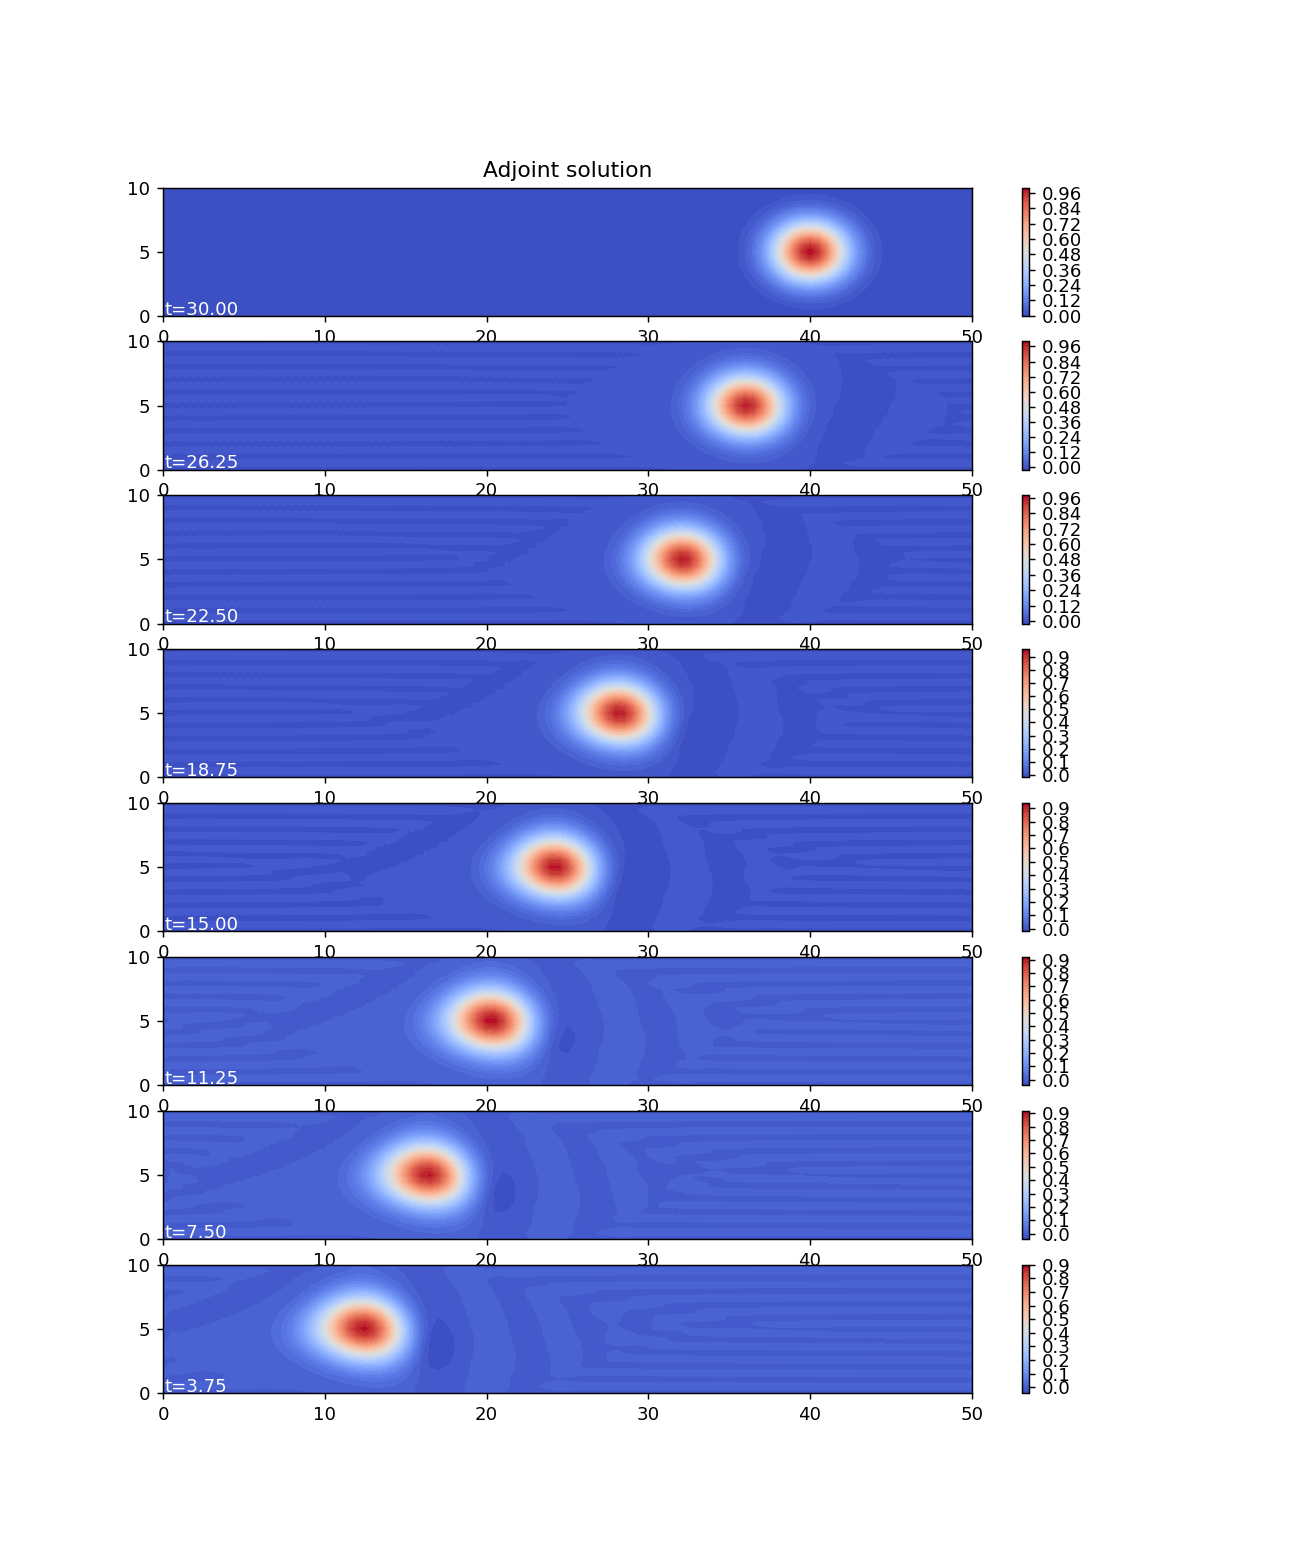

In [19]:
fig, axes = plt.subplots(len(adj_checkpoints), figsize=(10, 12))
axes[0].set_title("Adjoint solution")
for i, chk in enumerate(adj_checkpoints):
    ax = axes[num_windows-i-1]
    fig.colorbar(tricontourf(chk, axes=ax, cmap='coolwarm', levels=50), ax=ax);
    ax.annotate('t={:.2f}'.format((i+1)*end_time/num_windows), (0.1, 0.1), color='white');

Now consider an Hessian-based approach.

We split the time period $[0,T]$ into $N$ windows,

$$\mathcal W:=\left\{w_i:=\left[\frac{iT}N,\frac{(i+1)T}N\right]\quad\Big|\quad i=0:N-1\right\}.$$

For each window, we time integrate Hessians computed at each timestep using the `export_func` call:

$$H_i:=\int_{\frac{iT}N}^{\frac{(i+1)T}N}H(c)\;\mathrm dt,\qquad i=0:N-1.$$

The time integral should be evaluated using a quadrature rule which is appropriate for the timestepping routine.
It is straightforward to show that the Trapezium Rule is the one which matches Crank-Nicolson.

In [20]:
def trapezium_rule(f, h):
    """Written in a form which returns a Function, rather than an Expression."""
    out = f[0]
    out *= h*0.5
    out += h*0.5*f[-1]
    for i in range(1, len(f)-1):
        out += h*f[i]
    return out

Having time integrated the Hessians, we normalise in space and time in order to obtain useful Riemannian metrics for mesh adaptation.

In this time-accurate approach to mesh adaptation, the forward and adjoint PDEs are solved over the whole time period before the mesh adaptation step, following which they are solved again. Due to the time integration of the Hessian over each time window, we ensure that the metric (and hence the resulting mesh) remains valid for all timesteps in the window.

In [21]:
num_windows = 8
window_time = end_time/num_windows
dt_per_window = int(window_time/dt)
num_adapt = 2

# Create a mesh and a function space for each window
initial_mesh = RectangleMesh(50*n, 10*n, 50, 10)
meshes = [initial_mesh for i in range(num_windows)]
initial_space = FunctionSpace(initial_mesh, "CG", 1)
spaces = [initial_space for mesh in meshes]

op = TracerOptions(target=5000.0, norm_order=10)

for k in range(num_adapt):
    hessians = [[] for i in range(num_windows)]

    
    # --- Forward solve
    
    checkpoints = [Function(space) for space in spaces]
    checkpoints[0].assign(initial_condition(spaces[0]))
    exporter = File('plots/hessian_based/forward.pvd')
    for i in range(num_windows):
        exporter._topology = None  # This allows plotting multiple mesh windows in the save file

        # Create double L2 projector object which will be repeatedly used
        recoverer = DoubleL2ProjectorHessian(spaces[i], op=op)
        hessians_window = []

        def export_func(sol):
            """Do double L2 projection"""
            hessians_window.append(steady_metric(sol, projector=recoverer, noscale=True, normalise=False))

        # Solve advection-diffusion equation on window
        chk = solve_tracer(
            checkpoints[i], i*window_time, (i+1)*window_time, dt,
            export_func=export_func, exporter=exporter,
        )
        
        # Project between meshes
        if i < num_windows-1:
            if spaces[i] == spaces[i+1]:
                checkpoints[i+1].assign(chk)
            else:
                supermesh_project(chk, checkpoints[i+1])

        # Time integrate Hessian over window
        hessians[i] = trapezium_rule(hessians_window, dt)
        
    
    # --- Adjoint solve
    
    adj_checkpoints = [Function(space) for space in spaces]
    adj_checkpoints[-1].assign(final_time_condition(spaces[-1]))
    exporter = File('plots/hessian_based/adjoint.pvd')
    for i in range(num_windows-1, -1, -1):
        exporter._topology = None  # This allows plotting multiple mesh windows in the save file

        # Solve adjoint advection-diffusion equation on window
        chk = solve_tracer_adjoint(
            adj_checkpoints[i], (i+1)*window_time, i*window_time, dt,
            export_func=None, exporter=exporter,
        )
        
        # Project between meshes
        if i > 0:
            if spaces[i-1] == spaces[i]:
                adj_checkpoints[i-1].assign(chk)
            else:
                supermesh_project(chk, adj_checkpoints[i-1])
    
    
    # --- Mesh adaptation

    # Normalise Hessians in space and time
    t_int = [window_time/dt for H in hessians]
    space_time_normalise(hessians, timestep_integrals=t_int, op=op)
        
    # Adapt meshes
    if k < num_adapt-1:
        for i in range(num_windows):
            meshes[i] = adapt(meshes[i], hessians[i])
            spaces = [FunctionSpace(mesh, "CG", 1) for mesh in meshes]

<IPython.core.display.Javascript object>


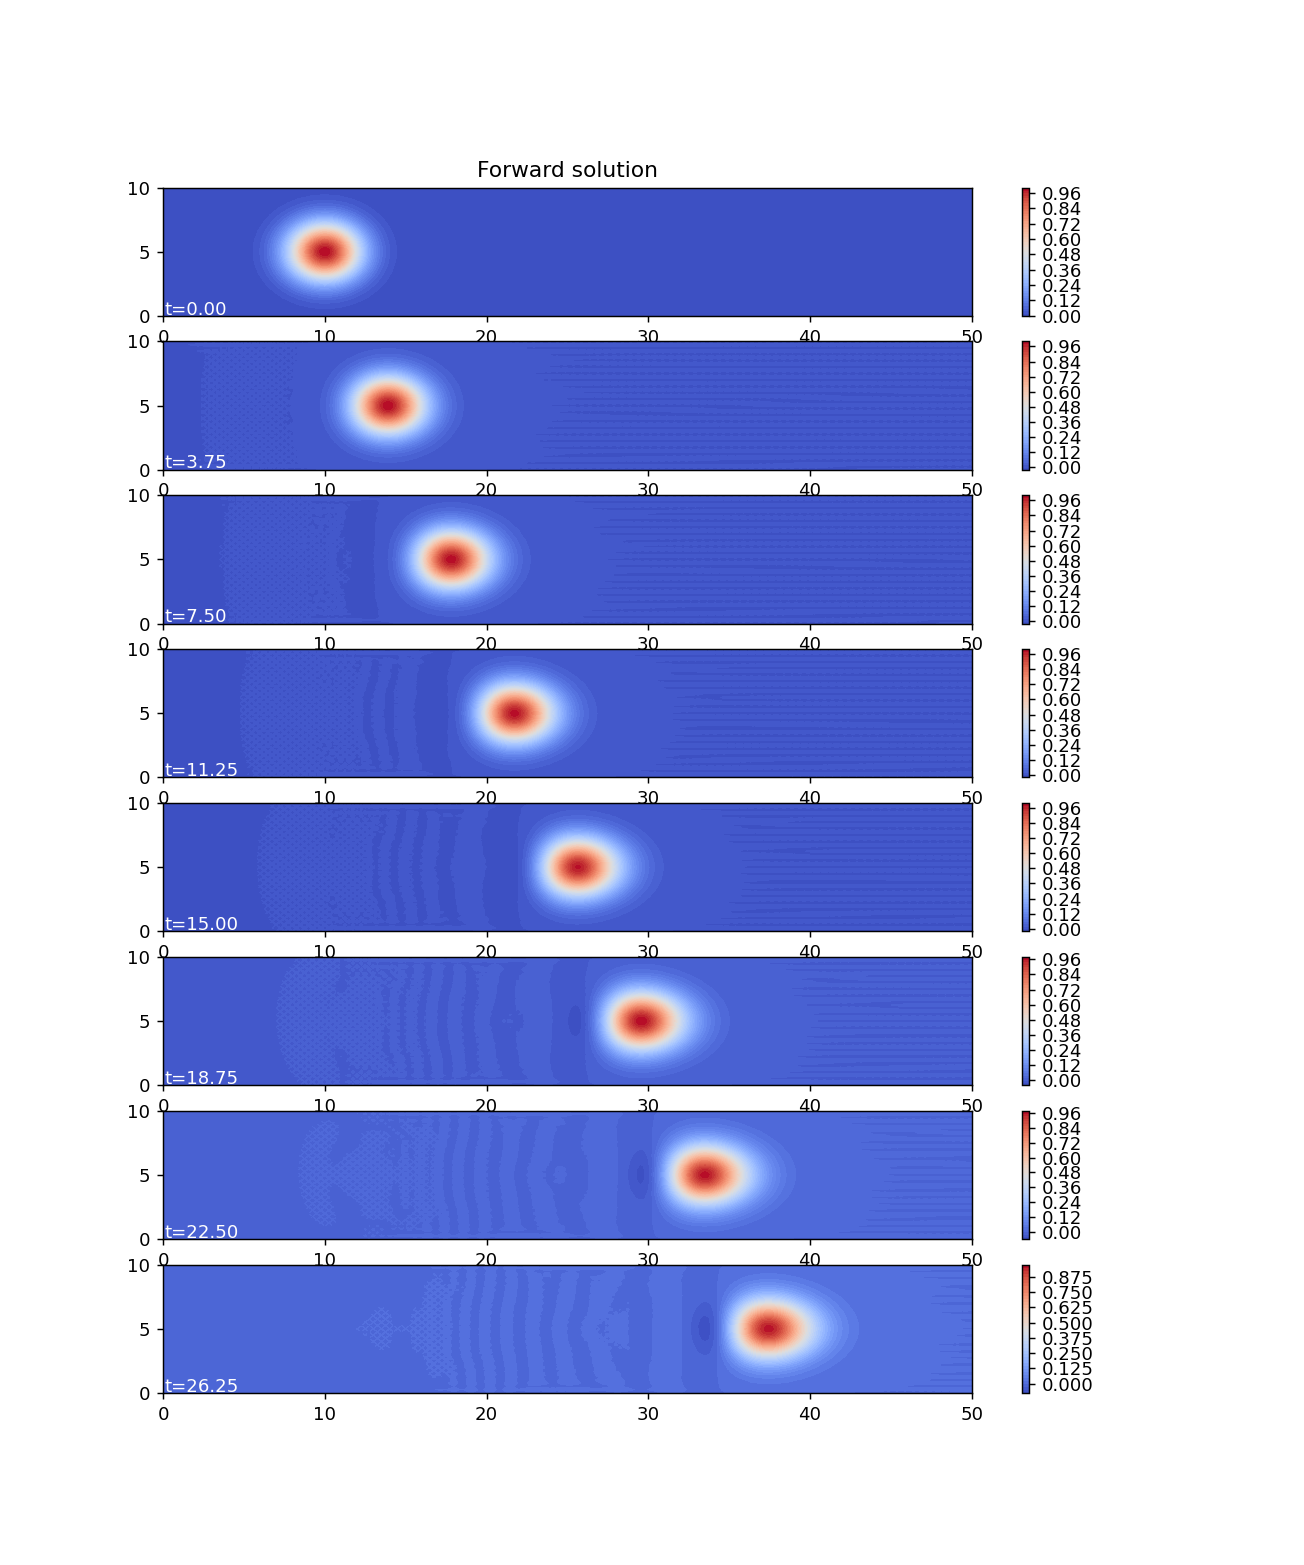

In [22]:
fig, axes = plt.subplots(len(checkpoints), figsize=(10, 12))
axes[0].set_title("Forward solution")
for i, chk in enumerate(checkpoints):
    fig.colorbar(tricontourf(chk, axes=axes[i], cmap='coolwarm', levels=50), ax=axes[i]);
    axes[i].annotate('t={:.2f}'.format(i*end_time/num_windows), (0.1, 0.1), color='white');

<IPython.core.display.Javascript object>


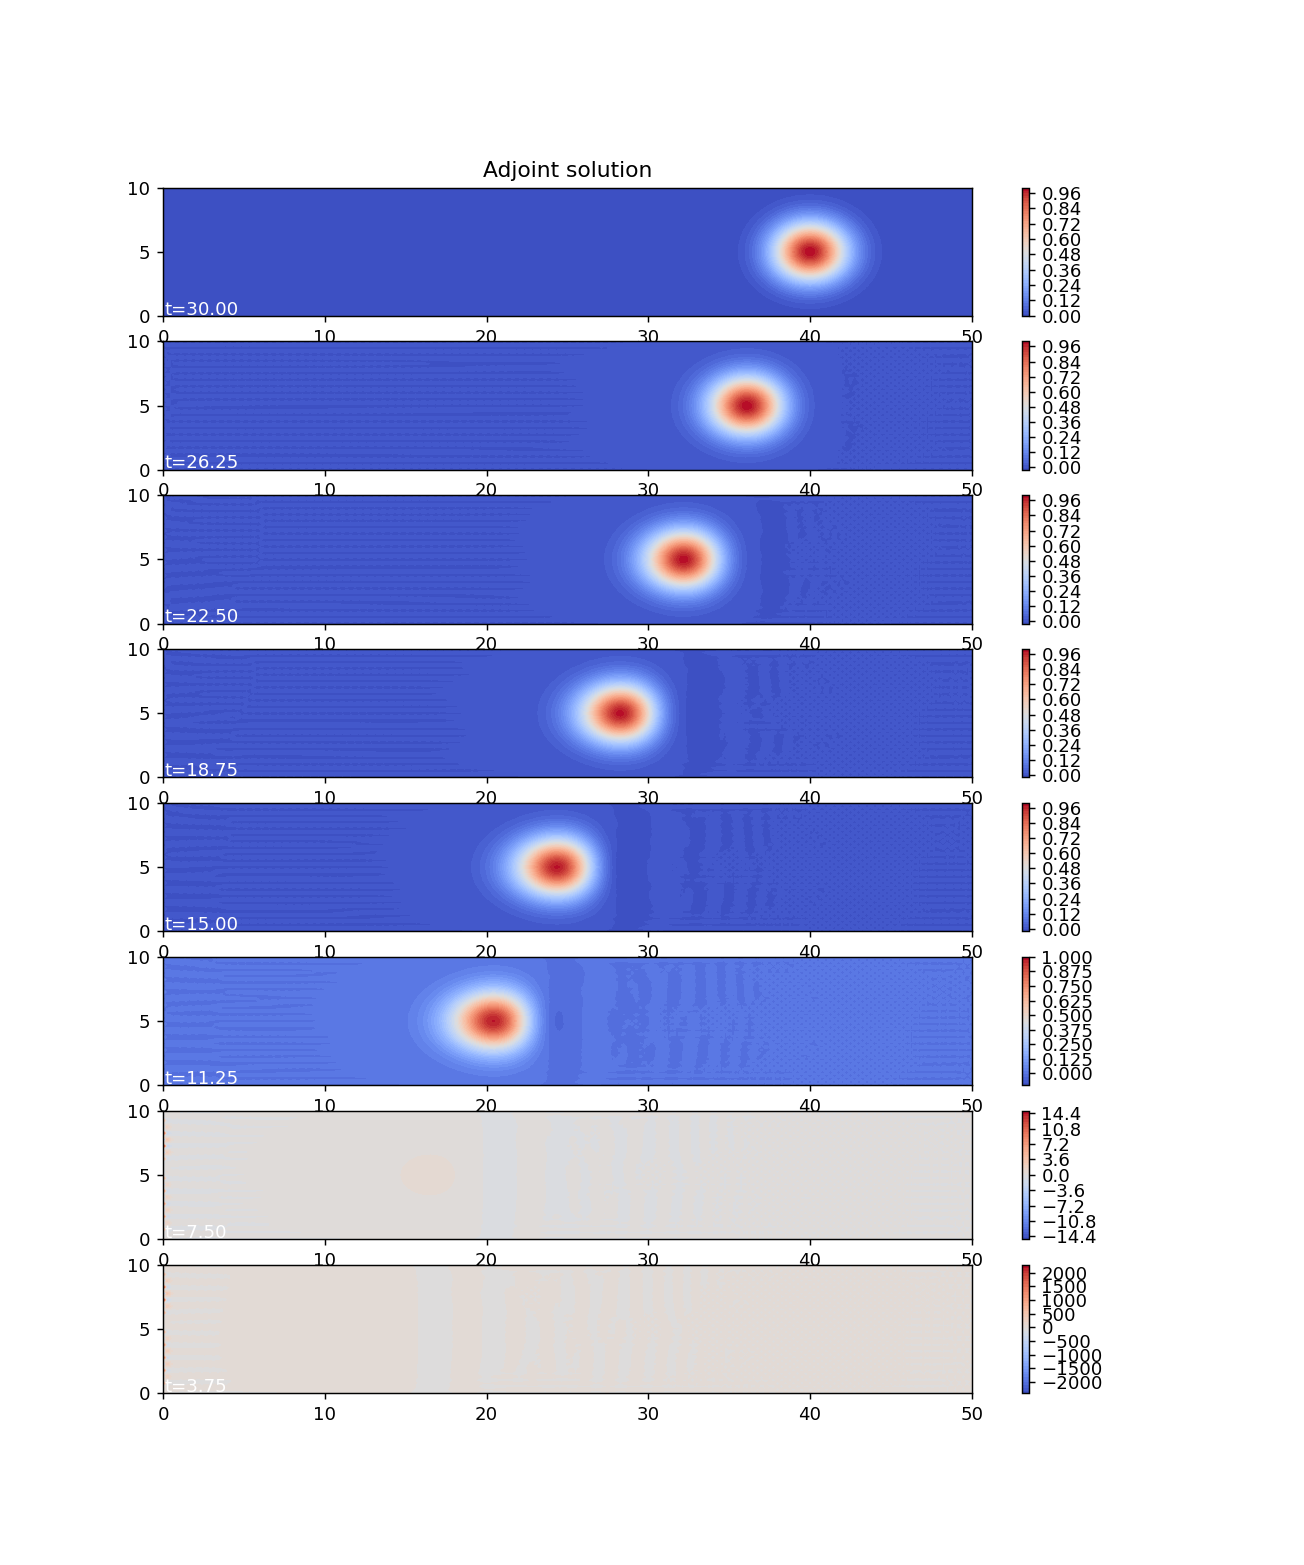

In [23]:
fig, axes = plt.subplots(len(adj_checkpoints), figsize=(10, 12))
axes[0].set_title("Adjoint solution")
for i, chk in enumerate(adj_checkpoints):
    ax = axes[num_windows-i-1]
    fig.colorbar(tricontourf(chk, axes=ax, cmap='coolwarm', levels=50), ax=ax);
    ax.annotate('t={:.2f}'.format((i+1)*end_time/num_windows), (0.1, 0.1), color='white');

The forward and adjoint solutions look reasonable enough, although the adjoint seems to blow up towards the end.

Now let's try doing the mesh-to-mesh projection using `supermesh_project_b` for the adjoint solve.

In [24]:
num_windows = 8
window_time = end_time/num_windows
dt_per_window = int(window_time/dt)
num_adapt = 2

# Create a mesh and a function space for each window
initial_mesh = RectangleMesh(50*n, 10*n, 50, 10)
meshes = [initial_mesh for i in range(num_windows)]
initial_space = FunctionSpace(initial_mesh, "CG", 1)
spaces = [initial_space for mesh in meshes]

op = TracerOptions(target=5000.0, norm_order=10)

for k in range(num_adapt):
    hessians = [[] for i in range(num_windows)]

    
    # --- Forward solve
    
    checkpoints = [Function(space) for space in spaces]
    checkpoints[0].assign(initial_condition(spaces[0]))
    exporter = File('plots/hessian_based/forward.pvd')
    for i in range(num_windows):
        exporter._topology = None  # This allows plotting multiple mesh windows in the save file

        # Create double L2 projector object which will be repeatedly used
        recoverer = DoubleL2ProjectorHessian(spaces[i], op=op)
        hessians_window = []

        def export_func(sol):
            """Do double L2 projection"""
            hessians_window.append(steady_metric(sol, projector=recoverer, noscale=True, normalise=False))

        # Solve advection-diffusion equation on window
        chk = solve_tracer(
            checkpoints[i], i*window_time, (i+1)*window_time, dt,
            export_func=export_func, exporter=exporter,
        )
        
        # Project between meshes
        if i < num_windows-1:
            if spaces[i] == spaces[i+1]:
                checkpoints[i+1].assign(chk)
            else:
                supermesh_project(chk, checkpoints[i+1])

        # Time integrate Hessian over window
        hessians[i] = trapezium_rule(hessians_window, dt)
        
    
    # --- Adjoint solve
    
    checkpoints = [Function(space) for space in spaces]
    checkpoints[-1].assign(final_time_condition(spaces[-1]))
    exporter = File('plots/hessian_based/adjoint.pvd')
    for i in range(num_windows-1, -1, -1):
        exporter._topology = None  # This allows plotting multiple mesh windows in the save file

        # Solve adjoint advection-diffusion equation on window
        chk = solve_tracer_adjoint(
            checkpoints[i], (i+1)*window_time, i*window_time, dt,
            export_func=None, exporter=exporter,
        )
        
        # Project between meshes
        if i > 0:
            if spaces[i-1] == spaces[i]:
                checkpoints[i-1].assign(chk)
            else:
                supermesh_project_b(chk, checkpoints[i-1])
    
    
    # --- Mesh adaptation

    # Normalise Hessians in space and time
    t_int = [window_time/dt for H in hessians]
    space_time_normalise(hessians, timestep_integrals=t_int, op=op)
        
    # Adapt meshes
    if k < num_adapt-1:
        for i in range(num_windows):
            meshes[i] = adapt(meshes[i], hessians[i])
            spaces = [FunctionSpace(mesh, "CG", 1) for mesh in meshes]

<IPython.core.display.Javascript object>


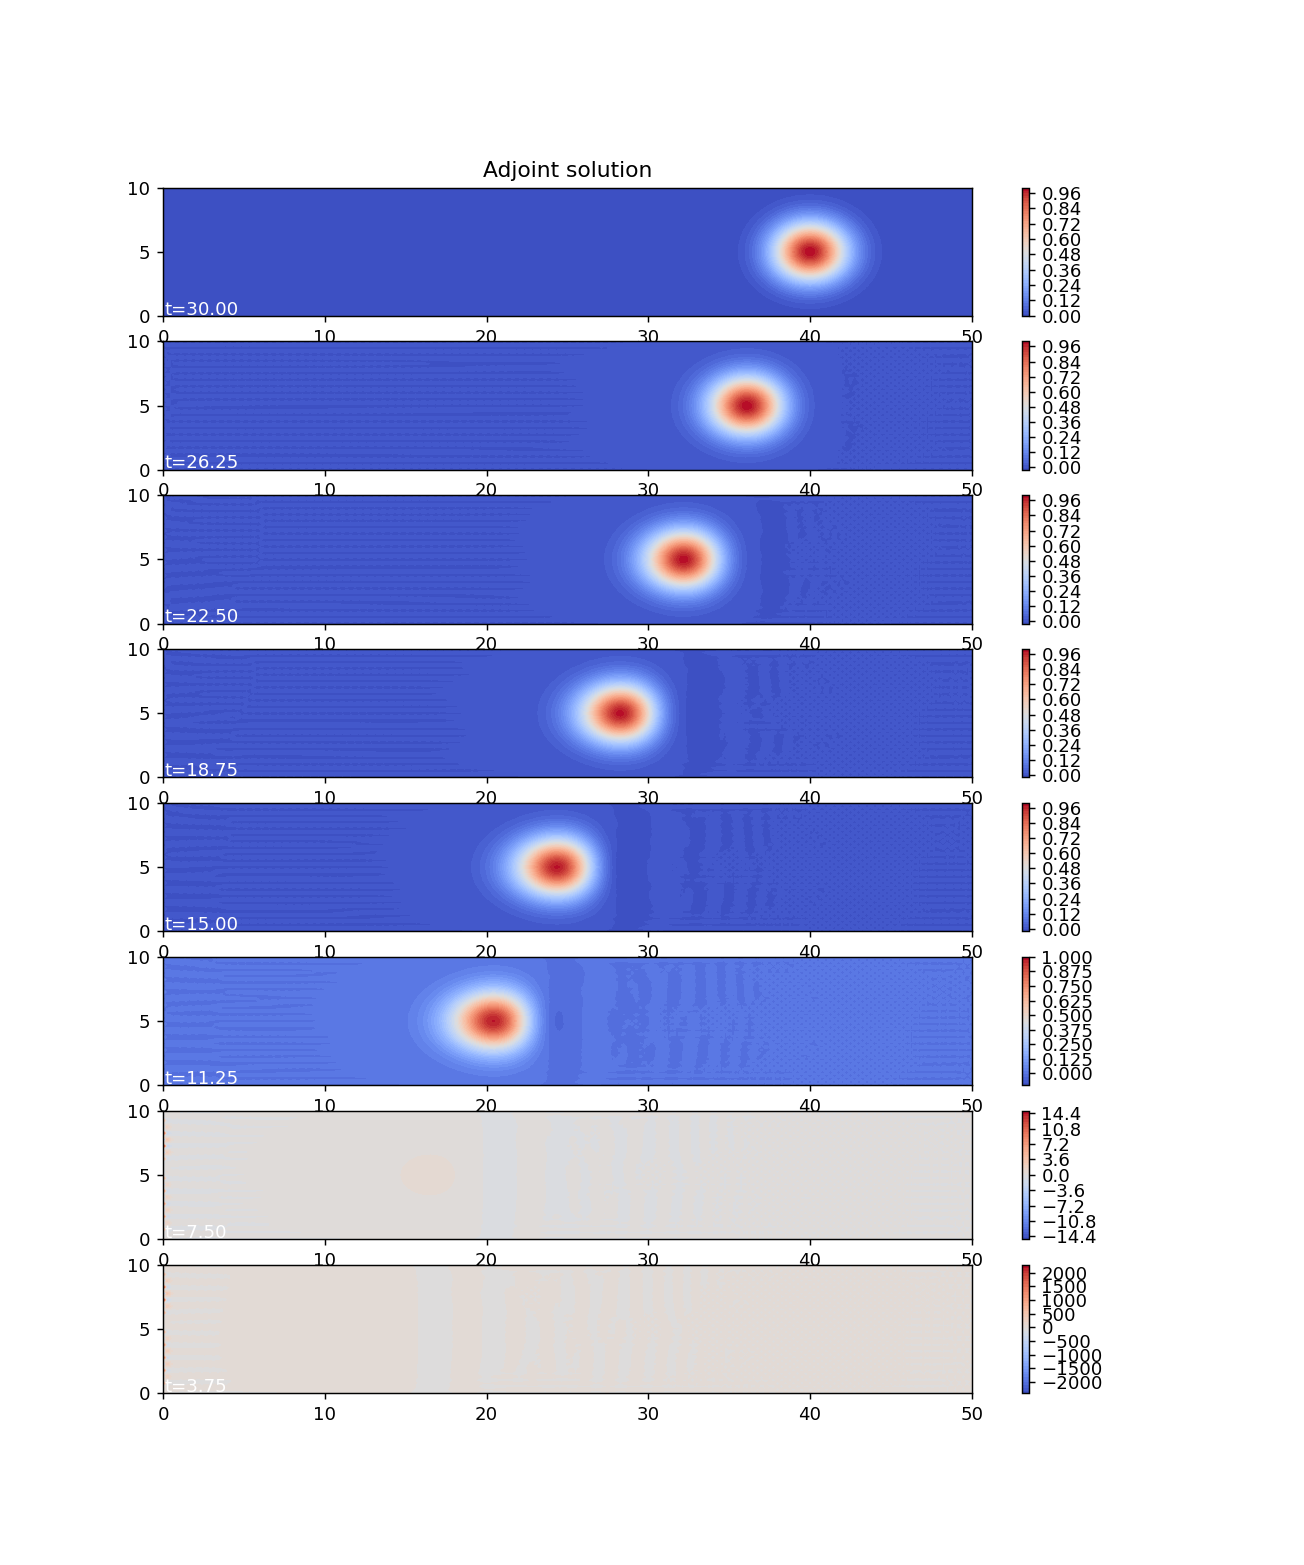

In [25]:
fig, axes = plt.subplots(len(adj_checkpoints), figsize=(10, 12))
axes[0].set_title("Adjoint solution")
for i, chk in enumerate(adj_checkpoints):
    ax = axes[num_windows-i-1]
    fig.colorbar(tricontourf(chk, axes=ax, cmap='coolwarm', levels=50), ax=ax);
    ax.annotate('t={:.2f}'.format((i+1)*end_time/num_windows), (0.1, 0.1), color='white');

We observe that the adjoint solution loses a significant amount of mass between each window!
This is not surprising, given what we saw in the `adjoint-by-hand` notebook.

We need a different interpolation operator if we are to take the adjoint and it be useful in practice!